# nuvT(neutrino interaction time) reconstruction

The goal of this project is to develop a neural network that uses the scintillation light produced in SBND, a liquid argon TPC exposed to a neutrino beam at Fermilab. The neural network uses the number of photoelectrons observed in each of the channels in an event as input. The output estimate is the temporal coordinate of the neutrino interaction.

This program employs a CNN composed of convolutional layers (along with MaxPooling) followed by a fully connected network. The input consists of "images" with the spatial correlation of the detector map, forming four layers (separating visible and ultraviolet detectors; and both volumes).

In [4]:
import uproot
import awkward as ak
import json

import statistics as st
import collections
from random import randint
#import visualkeras
from sklearn.metrics import mean_squared_error

#typical libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#tensorflow module
import tensorflow as tf
from tensorflow.keras import layers # type: ignore
from tensorflow.keras.models import Model # type: ignore
from tensorflow.keras.callbacks import ModelCheckpoint # type: ignore

prueba de github

## Root file analysis

The data corresponds to the Monte Carlo simulation of the SBND experiment. It was obtained by simulating the creation of neutrinos in the beam and their subsequent interaction in SBND, as well as the simulation of the detector's response to the particles resulting from the interaction of the neutrinos.

In [2]:
file_path = '../prueba_opana_tree.root'
file = uproot.open(file_path)
print("Keys in the file:", file.classnames())

FileNotFoundError: [Errno 2] No such file or directory: '/home/vidales/AI_nuvT/../prueba_opana_tree.root'

In [4]:
optree = file['opanatree']['OpAnaTree'] # Tree con número de fotoelectrones
print("Keys in optree:", optree.keys())

Keys in optree: ['eventID', 'runID', 'subrunID', 'nuvX', 'nuvY', 'nuvZ', 'nuvT', 'nuvE', 'stepX', 'stepY', 'stepZ', 'stepT', 'dE', 'energydep', 'energydepX', 'energydepY', 'energydepZ', 'E', 'StartPx', 'StartPy', 'StartPz', 'EndPx', 'EndPy', 'EndPz', 'process', 'trackID', 'motherID', 'PDGcode', 'InTimeCosmics', 'InTimeCosmicsTime', 'dEtpc', 'dEpromx', 'dEpromy', 'dEpromz', 'dEspreadx', 'dEspready', 'dEspreadz', 'dElowedges', 'dEmaxedges', 'SimPhotonsperOpChVUV', 'SimPhotonsperOpChVIS', 'NPhotons', 'NPhotonsPMTCo', 'NPhotonsPMTUnco', 'NPhotonsPMTCoVUV', 'NPhotonsXARAPUCAVUV', 'NPhotonsXARAPUCAVIS', 'SimPhotonsLiteVUV', 'SimPhotonsLiteVIS', 'nophits', 'ophit_opch', 'ophit_peakT', 'ophit_startT', 'ophit_riseT', 'ophit_width', 'ophit_area', 'ophit_amplitude', 'ophit_pe', 'nopflash', 'flash_id', 'flash_time', 'flash_total_pe', 'flash_pe_v', 'flash_tpc', 'flash_y', 'flash_yerr', 'flash_z', 'flash_zerr', 'flash_x', 'flash_xerr', 'flash_ophit_time', 'flash_ophit_risetime', 'flash_ophit_startti

Con la siguiente celda se pueden explorar las variables de OpAnaTree

In [5]:
var = 'nuvT'
optreevar = optree[var].array()

print("Lengths of individual sub-arrays:", ak.num(optreevar, axis=0))
print("Lengths of individual sub-arrays:", ak.num(optreevar, axis=1))

#for i in optreevar:
#  print(i)

Lengths of individual sub-arrays: 50
Lengths of individual sub-arrays: [1, 1, 1, 1, 2, 1, 1, 2, 1, 2, 1, 1, 1, ..., 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1]


In [ ]:

plt.figure(figsize=(20,8))
for i in range(1, len(optreevar)):
    branch_name = f"{i}"
    data = optreevar[i]
    plt.hist(data, bins=50, histtype='step', label=branch_name, alpha=0.7)


plt.xlabel("nuvT")
plt.ylabel("Frequency")
#plt.xlim(0,312)

plt.yticks([])
plt.title("nuvT in 50 events")
plt.show()

## Detector map

Para el interesado, ver en el final del notebook la sección Adicional donde se puede ver el mapa en 2d y 3d de los detectores. Estas matrices son una parametrización de ese mapa, pueden tener sentido otras también

In [22]:
coated_pmt_map = np.array(([-2,6,-2,-2,-2,-2,-2,-2,-2,60,-2,-2,84,-2,-2,-2,-2,-2,-2,-2,138,-2,-2,162,-2,-2,-2,-2,-2,-2,-2,216,-2,-2,240,-2,-2,-2,-2,-2,-2,-2,294,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,8,-2,-2,-2,-2,-2,-2,-2,62,-2,-2,86,-2,-2,-2,-2,-2,-2,-2,140,-2,-2,164,-2,-2,-2,-2,-2,-2,-2,218,-2,-2,242,-2,-2,-2,-2,-2,-2,-2,296,-2],
                           [-2,10,-2,-2,-2,-2,-2,-2,-2,64,-2,-2,88,-2,-2,-2,-2,-2,-2,-2,142,-2,-2,166,-2,-2,-2,-2,-2,-2,-2,220,-2,-2,244,-2,-2,-2,-2,-2,-2,-2,298,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,12,-2,-2,-2,-2,-2,-2,-2,66,-2,-2,90,-2,-2,-2,-2,-2,-2,-2,144,-2,-2,168,-2,-2,-2,-2,-2,-2,-2,222,-2,-2,246,-2,-2,-2,-2,-2,-2,-2,300,-2],
                           [-2,14,-2,-2,-2,-2,-2,-2,-2,68,-2,-2,92,-2,-2,-2,-2,-2,-2,-2,146,-2,-2,170,-2,-2,-2,-2,-2,-2,-2,224,-2,-2,248,-2,-2,-2,-2,-2,-2,-2,302,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,16,-2,-2,-2,-2,-2,-2,-2,70,-2,-2,94,-2,-2,-2,-2,-2,-2,-2,148,-2,-2,172,-2,-2,-2,-2,-2,-2,-2,226,-2,-2,250,-2,-2,-2,-2,-2,-2,-2,304,-2]))

uncoated_pmt_map = np.array(([-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,36,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,114,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,192,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,270,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,38,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,116,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,194,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,272,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,40,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,118,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,196,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,274,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2]))

xarap_vuv_map = np.array(([-2,-2,-2,-2,-2,-2,42,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,120,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,198,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,276,-2,-2,-2,-2],
                           [-2,-2,18,-2,-2,-2,-2,-2,-2,-2,72,-2,-2,96,-2,-2,-2,-2,-2,-2,-2,150,-2,-2,174,-2,-2,-2,-2,-2,-2,-2,228,-2,-2,252,-2,-2,-2,-2,-2,-2,-2,306],
                           [-2,-2,-2,-2,-2,-2,44,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,122,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,200,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,278,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,46,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,124,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,202,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,280,-2,-2,-2,-2],
                           [-2,-2,10,-2,-2,-2,-2,-2,-2,-2,74,-2,-2,98,-2,-2,-2,-2,-2,-2,-2,152,-2,-2,176,-2,-2,-2,-2,-2,-2,-2,230,-2,-2,254,-2,-2,-2,-2,-2,-2,-2,308],
                           [-2,-2,-2,-2,-2,-2,48,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,126,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,204,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,282,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,50,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,128,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,206,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,284,-2,-2,-2,-2],
                           [-2,-2,22,-2,-2,-2,-2,-2,-2,-2,76,-2,-2,100,-2,-2,-2,-2,-2,-2,-2,154,-2,-2,178,-2,-2,-2,-2,-2,-2,-2,232,-2,-2,256,-2,-2,-2,-2,-2,-2,-2,310],
                           [-2,-2,-2,-2,-2,-2,52,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,130,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,208,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,286,-2,-2,-2,-2]))

xarap_vis_map = np.array(([-2,-2,-2,-2,24,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,102,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,180,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,258,-2,-2,-2,-2,-2,-2],
                           [0,-2,-2,-2,-2,-2,-2,-2,54,-2,-2,78,-2,-2,-2,-2,-2,-2,-2,132,-2,-2,156,-2,-2,-2,-2,-2,-2,-2,210,-2,-2,234,-2,-2,-2,-2,-2,-2,-2,288,-2,-2],
                           [-2,-2,-2,-2,26,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,104,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,182,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,260,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,28,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,106,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,184,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,262,-2,-2,-2,-2,-2,-2],
                           [2,-2,-2,-2,-2,-2,-2,-2,56,-2,-2,80,-2,-2,-2,-2,-2,-2,-2,134,-2,-2,158,-2,-2,-2,-2,-2,-2,-2,212,-2,-2,236,-2,-2,-2,-2,-2,-2,-2,290,-2,-2],
                           [-2,-2,-2,-2,30,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,108,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,186,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,264,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,32,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,110,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,188,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,266,-2,-2,-2,-2,-2,-2],
                           [4,-2,-2,-2,-2,-2,-2,-2,58,-2,-2,82,-2,-2,-2,-2,-2,-2,-2,136,-2,-2,160,-2,-2,-2,-2,-2,-2,-2,214,-2,-2,238,-2,-2,-2,-2,-2,-2,-2,292,-2,-2],
                           [-2,-2,-2,-2,34,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,112,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,190,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,268,-2,-2,-2,-2,-2,-2]))

#joining CoatedPMTs and VUV XARAP 
vuv_map = np.array([[-2,6,-2,-2,-2,-2,42,-2,-2,60,-2,-2,84,-2,-2,-2,-2,120,-2,-2,138,-2,-2,162,-2,-2,-2,-2,198,-2,-2,216,-2,-2,240,-2,-2,-2,-2,276,-2,-2,294,-2],
                    [-2,-2,18,-2,-2,-2,-2,-2,-2,-2,72,-2,-2,96,-2,-2,-2,-2,-2,-2,-2,150,-2,-2,174,-2,-2,-2,-2,-2,-2,-2,228,-2,-2,252,-2,-2,-2,-2,-2,-2,-2,306],
                    [-2,8,-2,-2,-2,-2,44,-2,-2,62,-2,-2,86,-2,-2,-2,-2,122,-2,-2,140,-2,-2,164,-2,-2,-2,-2,200,-2,-2,218,-2,-2,242,-2,-2,-2,-2,278,-2,-2,296,-2],
                    [-2,10,-2,-2,-2,-2,46,-2,-2,64,-2,-2,88,-2,-2,-2,-2,124,-2,-2,142,-2,-2,166,-2,-2,-2,-2,202,-2,-2,220,-2,-2,244,-2,-2,-2,-2,280,-2,-2,298,-2],
                    [-2,-2,10,-2,-2,-2,-2,-2,-2,-2,74,-2,-2,98,-2,-2,-2,-2,-2,-2,-2,152,-2,-2,176,-2,-2,-2,-2,-2,-2,-2,230,-2,-2,254,-2,-2,-2,-2,-2,-2,-2,308],
                    [-2,12,-2,-2,-2,-2,48,-2,-2,66,-2,-2,90,-2,-2,-2,-2,126,-2,-2,144,-2,-2,168,-2,-2,-2,-2,204,-2,-2,222,-2,-2,246,-2,-2,-2,-2,282,-2,-2,300,-2],
                    [-2,14,-2,-2,-2,-2,50,-2,-2,68,-2,-2,92,-2,-2,-2,-2,128,-2,-2,146,-2,-2,170,-2,-2,-2,-2,206,-2,-2,224,-2,-2,248,-2,-2,-2,-2,284,-2,-2,302,-2],
                    [-2,-2,22,-2,-2,-2,-2,-2,-2,-2,76,-2,-2,100,-2,-2,-2,-2,-2,-2,-2,154,-2,-2,178,-2,-2,-2,-2,-2,-2,-2,232,-2,-2,256,-2,-2,-2,-2,-2,-2,-2,310],
                    [-2,16,-2,-2,-2,-2,52,-2,-2,70,-2,-2,94,-2,-2,-2,-2,130,-2,-2,148,-2,-2,172,-2,-2,-2,-2,208,-2,-2,226,-2,-2,250,-2,-2,-2,-2,286,-2,-2,304,-2]])

#joining CoatedPMTs, UncoatedPMTs and VIS XARAP 
vis_map = np.array([[-2,6,-2,-2,24,-2,-2,-2,-2,60,-2,-2,84,-2,-2,102,-2,-2,-2,-2,138,-2,-2,162,-2,-2,180,-2,-2,-2,-2,216,-2,-2,240,-2,-2,258,-2,-2,-2,-2,294,-2],
                    [0,-2,-2,-2,-2,36,-2,-2,54,-2,-2,78,-2,-2,-2,-2,114,-2,-2,132,-2,-2,156,-2,-2,-2,-2,192,-2,-2,210,-2,-2,234,-2,-2,-2,-2,270,-2,-2,288,-2,-2],
                    [-2,8,-2,-2,26,-2,-2,-2,-2,62,-2,-2,86,-2,-2,104,-2,-2,-2,-2,140,-2,-2,164,-2,-2,182,-2,-2,-2,-2,218,-2,-2,242,-2,-2,260,-2,-2,-2,-2,296,-2],
                    [-2,10,-2,-2,28,-2,-2,-2,-2,64,-2,-2,88,-2,-2,106,-2,-2,-2,-2,142,-2,-2,166,-2,-2,184,-2,-2,-2,-2,220,-2,-2,244,-2,-2,262,-2,-2,-2,-2,298,-2],
                    [2,-2,-2,-2,-2,38,-2,-2,56,-2,-2,80,-2,-2,-2,-2,116,-2,-2,134,-2,-2,158,-2,-2,-2,-2,194,-2,-2,212,-2,-2,236,-2,-2,-2,-2,272,-2,-2,290,-2,-2],
                    [-2,12,-2,-2,30,-2,-2,-2,-2,66,-2,-2,90,-2,-2,108,-2,-2,-2,-2,144,-2,-2,168,-2,-2,186,-2,-2,-2,-2,222,-2,-2,246,-2,-2,264,-2,-2,-2,-2,300,-2],
                    [-2,14,-2,-2,32,-2,-2,-2,-2,68,-2,-2,92,-2,-2,110,-2,-2,-2,-2,146,-2,-2,170,-2,-2,188,-2,-2,-2,-2,224,-2,-2,248,-2,-2,266,-2,-2,-2,-2,302,-2],
                    [4,-2,-2,-2,-2,40,-2,-2,58,-2,-2,82,-2,-2,-2,-2,118,-2,-2,136,-2,-2,160,-2,-2,-2,-2,196,-2,-2,214,-2,-2,238,-2,-2,-2,-2,274,-2,-2,292,-2,-2],
                    [-2,16,-2,-2,34,-2,-2,-2,-2,70,-2,-2,94,-2,-2,112,-2,-2,-2,-2,148,-2,-2,172,-2,-2,190,-2,-2,-2,-2,226,-2,-2,250,-2,-2,268,-2,-2,-2,-2,304,-2]])

#minimum matrix - PDS box 3*9
coated_pmt_map_minimum = np.delete(coated_pmt_map, [3,7,14,18,25,29,36,40],  axis=1)
uncoated_pmt_map_minimum = np.delete(uncoated_pmt_map, [3,7,14,18,25,29,36,40],  axis=1)
xarap_vuv_map_minimum = np.delete(xarap_vuv_map, [3,7,14,18,25,29,36,40],  axis=1)
xarap_vis_map_minimum = np.delete(xarap_vis_map, [3,7,14,18,25,29,36,40],  axis=1)
vuv_map_min = np.delete(vuv_map, [3,7,14,18,25,29,36,40],  axis=1)
vis_map_min = np.delete(vis_map, [3,7,14,18,25,29,36,40],  axis=1)
#necesitaremos construir los dos planos con el siguiente código:
vis_map_min = np.row_stack((vis_map_min,vis_map_min+1))
vuv_map_min = np.row_stack((vuv_map_min,vuv_map_min+1))

vis_map=vis_map_min
vuv_map=vuv_map_min

In [14]:
# Carga asociada a cada evento, hit, canal y tiempo
hit_PE = optree['flash_ophit_pe'].array()
print(hit_PE.type)
# Canal asociado a cada evento, hit, carga recogida y tiempo
hit_ch = optree['flash_ophit_ch'].array()
# Tiempo asociado a cada evento, hit, canal y carga recogida
hit_t = optree['flash_ophit_time'].array()

50 * var * var * float64


*¿Porque negativos?*

In [16]:
print(hit_t[4])

[[-603, -603, -603, -603, -603, -603, ..., -610, -610, -610, -610, -610], ...]


In [19]:
n_eventos = len(hit_ch)
n_canales = 312

# Creamos la matriz donde guardar el número de fotoelectrones recogidos en cada canal y por cada evento
fotoelectrones = np.zeros((n_eventos,n_canales))
tiempos = np.zeros((n_eventos,n_canales))

for i in range(n_eventos):
  max_carga_indice = np.zeros(n_canales)
  for j in range(len(hit_PE[i])):
    for k, l, t in zip(hit_PE[i][j], hit_ch[i][j], hit_t[i][j]):
      fotoelectrones[i][l] += k
      tiempos[i][l] += k*t # Ponderamos usando como pesos las cargas

In [20]:
# Se normaliza con la suma total de los pesos, que es la matriz de fotoelectrones
for i in range(n_eventos):
  for j in range(n_canales):
    if fotoelectrones[i][j] != 0:
      tiempos[i][j] /= fotoelectrones[i][j]
    else:
      tiempos[i][j] = 0

In [24]:
ch_y = 18
ch_z = 9

# Creamos la matriz con distribución espacial
fotoelectrones_vis_map = np.zeros((n_eventos,ch_z*2,ch_y*2))
fotoelectrones_vuv_map = np.zeros((n_eventos,ch_z*2,ch_y*2))

tiempos_vis_map = np.zeros((n_eventos,ch_z*2,ch_y*2))
tiempos_vuv_map = np.zeros((n_eventos,ch_z*2,ch_y*2))

for i in range(n_eventos):
  for j in range(ch_z*2):
    for k in range(ch_y*2):
      if vis_map[j][k] >= 0:
        fotoelectrones_vis_map[i][j][k] = fotoelectrones[i][vis_map[j][k]]
        tiempos_vis_map[i][j][k] = tiempos[i][vis_map[j][k]]
      if vuv_map[j][k] >= 0:
        fotoelectrones_vuv_map[i][j][k] = fotoelectrones[i][vuv_map[j][k]]
        tiempos_vuv_map[i][j][k] = tiempos[i][vuv_map[j][k]]

# Dividimos los sensores de diferente radiación en dos capas distintas y también por volúmenes
fotoelectrones_vis_map = np.hsplit(fotoelectrones_vis_map, 2)/np.max(fotoelectrones)
fotoelectrones_vuv_map = np.hsplit(fotoelectrones_vuv_map, 2)/np.max(fotoelectrones)

tiempos_vis_map = np.hsplit(tiempos_vis_map, 2)/np.max(tiempos)
tiempos_vuv_map = np.hsplit(tiempos_vuv_map, 2)/np.max(tiempos)

image = np.zeros((np.shape(fotoelectrones_vis_map[0])[0],np.shape(fotoelectrones_vis_map[0])[1],np.shape(fotoelectrones_vis_map[0])[2],8))

image[:,:,:,0] = fotoelectrones_vis_map[0]
image[:,:,:,1] = fotoelectrones_vis_map[1]
image[:,:,:,2] = fotoelectrones_vuv_map[0]
image[:,:,:,3] = fotoelectrones_vuv_map[1]

image[:,:,:,4] = tiempos_vis_map[0]
image[:,:,:,5] = tiempos_vis_map[1]
image[:,:,:,6] = tiempos_vuv_map[0]
image[:,:,:,7] = tiempos_vuv_map[1]


print('Number of events, image height, width, layers:', np.shape(image))

Number of events, image height, width, layers: (50, 9, 36, 8)



# Visualización de los datos



¿Porque los tiempos aparecen raros?

C1: Visible/Volumen -  ||  C2: Visible/Volumen +  ||  C3: Ultravioleta/Volumen -  ||  C4: Ultravioleta/Volumen +  ||


[]

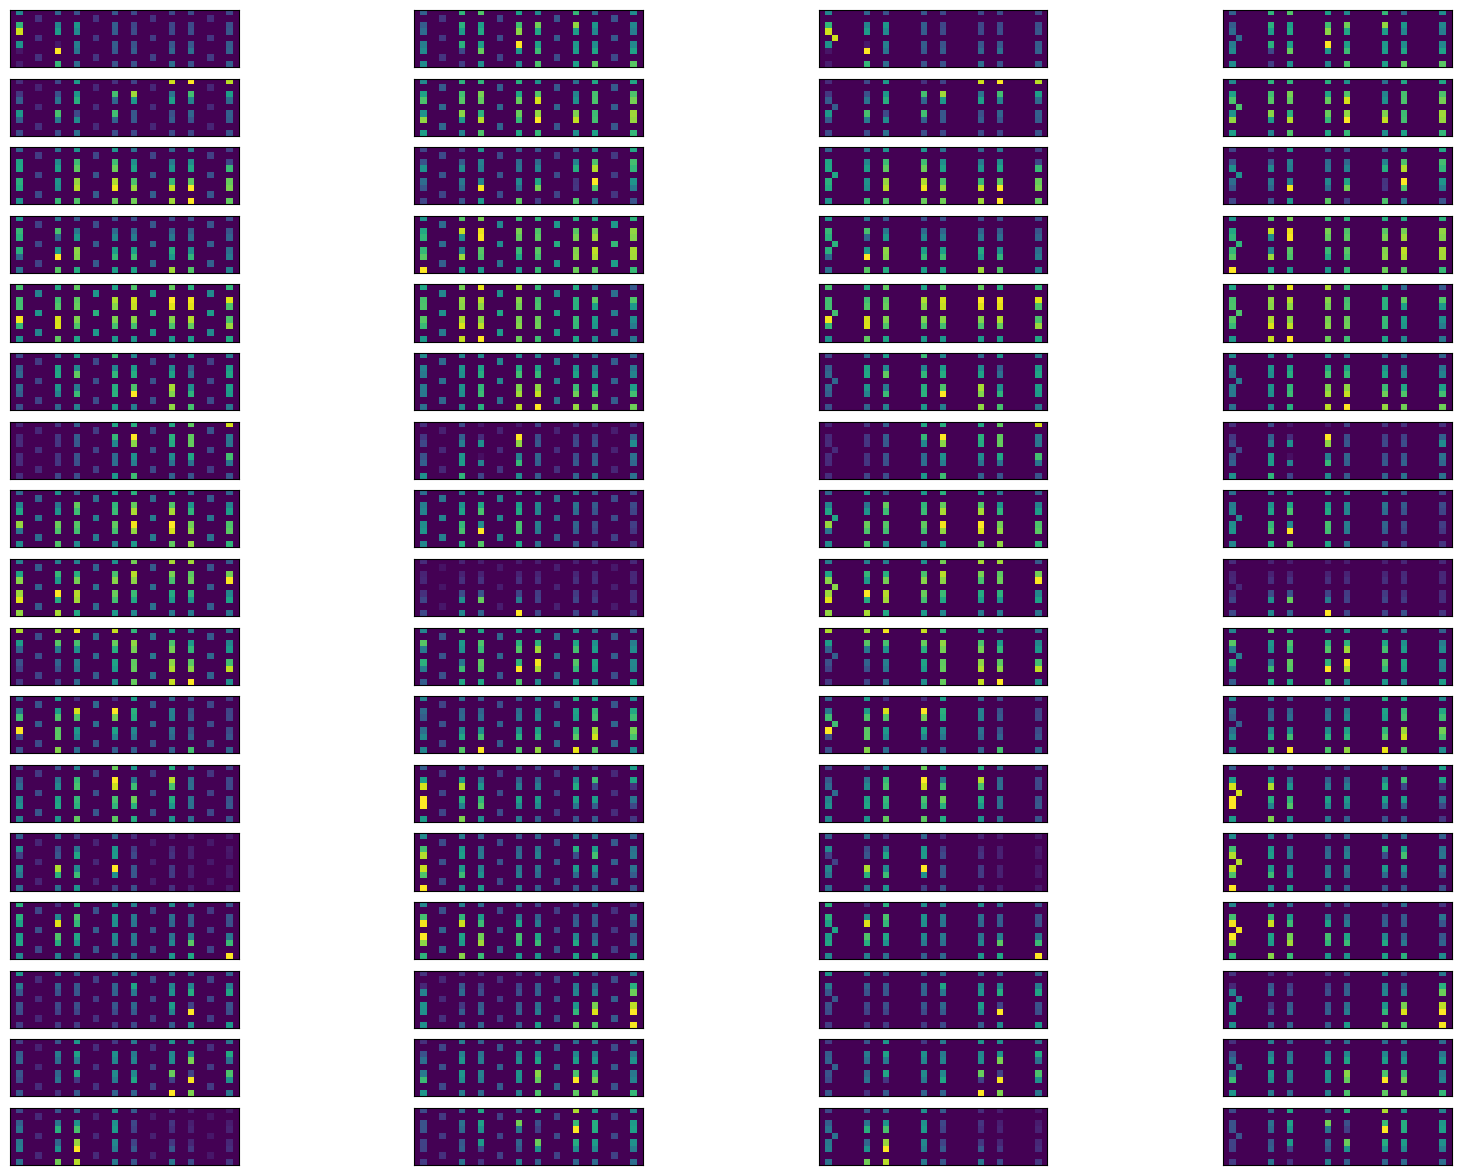

In [25]:
event_index = np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

print('C1: Visible/Volumen -  ||  C2: Visible/Volumen +  ||  C3: Ultravioleta/Volumen -  ||  C4: Ultravioleta/Volumen +  ||')
#T1: Visible/Volumen -  ||  T2: Visible/Volumen +  ||  T3: Ultravioleta/Volumen -  ||  T4: Ultravioleta/Volumen +
fig, axs = plt.subplots(17, 4, figsize=(20, 15))

for i in range(17):
  for j in range(4):
    axs[i,j].imshow(image[event_index[i],:,:,j])

plt.setp(axs, xticks=[], yticks=[])



# Reconstrucción de las coordenadas de forma individual

## Separación de los conjuntos de entrenamiento y prueba

In [26]:
hit_nuvT = optree['nuvT'].array()

#for i, subarray in enumerate(hit_nuvT):
#    print(f"Subarray {i}:", subarray)

Verificamos la dimensionalidad

In [28]:
assert np.shape(image)[0] == np.shape(hit_nuvT)[0]

ValueError: cannot convert to RegularArray because subarray lengths are not regular (in compiled code: https://github.com/scikit-hep/awkward/blob/awkward-cpp-37/awkward-cpp/src/cpu-kernels/awkward_ListOffsetArray_toRegularArray.cpp#L22)

Separamos el 60% de los datos para formar el conjunto de prueba

In [ ]:
test_size = int(np.floor(0.60*np.shape(Hit_nuvT)[0]) )
print(test_size)

In [ ]:
train_nuvTxarap, test_nuvTxarap = image[:-test_size], image[-test_size:]

train_nuvT, test_nuvT = Hit_nuvT[:-test_size], Hit_nuvT[-test_size:]

print(train_nuvTxarap.shape,test_nuvTxarap.shape)
print(len(train_nuvT),len(test_nuvT))


In [ ]:
input = layers.Input(shape=(train_nuvTxarap.shape[1], train_nuvTxarap.shape[2], train_nuvTxarap.shape[3]))

model = layers.BatchNormalization()(input)

model = layers.Conv2D(128, (3, 3), padding='same')(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D((2, 2),padding='same')(model)
model = layers.Dropout(0.3)(model)

model = layers.Conv2D(256, (3, 3), padding='same')(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
model = layers.Dropout(0.3)(model)

model = layers.Conv2D(512, (3, 3), padding='same')(model)
model = layers.LeakyReLU(alpha=0.1)(model)
model = layers.MaxPooling2D(pool_size=(2, 2),padding='same')(model)
model = layers.Dropout(0.4)(model)

model = layers.Flatten()(model)

model = layers.Dense(2048, activation='relu')(model)
model = layers.Dropout(0.2)(model)

model = layers.Dense(512, activation='relu')(model)
model = layers.Dense(128, activation='relu')(model)

output = layers.Dense(1, activation='linear')(model)

# Entrenando el modelo en la coordenada t

Se compila el modelo, incluyendo la elección del optimizador y del error que se minimizará durante el entrenamiento.

In [ ]:
# Creamos los modelos:
model_nuvT = Model(input, output)

In [ ]:
model_nuvT.summary()
model_nuvT.compile(loss='mse', optimizer='adam', metrics='mse')

In [ ]:
best_weights_file = "/tmp/weights_nuvT.hdf5"
checkpoint = ModelCheckpoint(best_weights_file, monitor='mse', verbose=0, save_best_only=True, mode='min')

# probar a modificar el batch_size (hacerlo más grande)
callbacks = [checkpoint]
history_t = model_nuvT.fit(train_nuvTxarap, train_nuvT,
                        epochs=30, batch_size=32, callbacks=callbacks,
                        validation_data=(test_nuvTxarap, test_nuvT),
                        verbose=2)

In [ ]:
best_weights_file = "/tmp/weights_nuvT.hdf5"
model_nuvT.load_weights(best_weights_file)
nuvT_pred = model_nuvT.predict(test_nuvTxarap)

# Visualización de resultados

Se calcula el error cuadrático medio del pronóstico.

In [ ]:
testScoreECM_nuvT = mean_squared_error(test_nuvT, nuvT_pred)
print('RECM_nuvT: %.4f' % np.sqrt((testScoreECM_nuvT)))

En la siguiente gráfica se visualiza la evolución del error para el conjunto de entrenamiento y test en función de las épocas.

In [ ]:
plt.figure(1, figsize=(8,8))
plt.plot(history_t.history['mse'])
plt.plot(history_t.history['val_mse'])

plt.yscale("log")
plt.title('Error del Modelo nuvT')
plt.ylabel('loss')
plt.xlabel('épocas')
plt.grid()
plt.legend(['train', 'test'], loc='upper center')
plt.show()

Es importante verificar hasta donde sea posible la distribución de errores. En la siguiente gráfica se muestra el pronóstico contra los datos reales.

In [ ]:
fig, axs = plt.subplots(1,2,figsize=(16,9))

axs[0].scatter(test_nuvT, nuvT_pred, color="black",s=5)
axs[0].grid()

axs[0].plot([0,1500],[0,1500],color="r")
axs[0].title.set_text('nuvT')
axs[0].set_xlim([0,1500])
axs[0].set_ylim([0,1500])
axs[0].set_ylabel('Pronóstico [ns]')
axs[0].set_xlabel('Real [ns]')


im1 = axs[1].hist2d(test_nuvT, nuvT_pred.flatten(), bins=(100, 300), cmap='viridis',cmax=30)
fig.colorbar(im1[3], ax=axs[1])
axs[1].grid()

axs[1].plot([0,1500],[0,1500],color="r")
axs[1].set_xlim([0,1500])
axs[1].set_ylim([0,1500])
axs[1].set_ylabel('Pronóstico [ns]')
axs[1].set_xlabel('Real [ns]')
axs[1].set_facecolor('#440154')

fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Recta_I.png', dpi=300)

Finalmente se realizan ajustes gaussianos al error entre pronóstico y datos reales para comprobar la calidad de los resultados.

In [ ]:
# Ajuste gaussiano de las diferencias entre el pronóstico y el valor real

from scipy.optimize import curve_fit

# Define the Gaussian function
def func(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

# Variables de los histogramas
diff_nuvT = nuvT_pred.flatten()-test_nuvT

fig, axs = plt.subplots(figsize=(10,6))

# Valores de X
axs.title.set_text('nuvT')
counts_nuvT, bins_nuvT, patches_nuvT = axs.hist(diff_nuvT,120, range=[-400,400], label='Datos')

step_nuvT = (bins_nuvT[1]-bins_nuvT[0])/2
bin_centers_nuvT = bins_nuvT[:-1]+step_nuvT

ini_nuvT = 0
fin_nuvT = 119
axs.axvline(x = bin_centers_nuvT[ini_nuvT], color = 'k', label='Bordes del ajuste')
axs.axvline(x = bin_centers_nuvT[fin_nuvT], color = 'k')

popt_nuvT, pcov_nuvT = curve_fit(func, bin_centers_nuvT[ini_nuvT:fin_nuvT+1], counts_nuvT[ini_nuvT:fin_nuvT+1])


ym_nuvT = func(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), popt_nuvT[0], popt_nuvT[1], popt_nuvT[2])
axs.plot(np.linspace(bin_centers_nuvT[ini_nuvT], bin_centers_nuvT[fin_nuvT],100), ym_nuvT, c='r', label='Ajuste')
axs.set_xlabel('Bias [ns]')
axs.legend(prop = { "size": 7 })

fig.supylabel('Conteo')
fig.tight_layout()

# plt.savefig('/tmp/CNNx2+4T+N_Distrib_I.png', dpi=300)

print('------------------')
print('Media nuvT =',popt_nuvT[1])
print('Sigma nuvT =',popt_nuvT[2])
print('------------------')


In [ ]:
print('Gauss nuvT')
print(np.std(diff_nuvT))
print(np.mean(diff_nuvT))

## Variables in OpAnaTree

### Event and Identification Variables:
- **`eventID`**: The unique identifier for a particular event (interaction or triggered readout) in the detector.
- **`runID`**: Identifier for the run during which the event was recorded. A run is a specific period during which the detector collects data.
- **`subrunID`**: A further subdivision of a run, useful for managing large data sets or specific calibration periods within a run.

### Neutrino Interaction Variables:
- **`nuvX`, `nuvY`, `nuvZ`, `nuvT`**: The position (`X`, `Y`, `Z`) and time (`T`) of the neutrino interaction vertex. This is where the neutrino is believed to have interacted with the argon nucleus.
- **`nuvE`**: The energy of the incoming neutrino at the interaction vertex.

### Particle Track and Energy Deposition Variables:
- **`stepX`, `stepY`, `stepZ`, `stepT`**: The position and time for each step of a particle’s track through the detector, likely as it deposits energy in the LArTPC.
- **`dE`**: The energy deposited in a single step, potentially along a track in the detector.
- **`energydep`, `energydepX`, `energydepY`, `energydepZ`**: The total energy deposited and the components of energy deposition in the `X`, `Y`, and `Z` directions.
- **`E`**: The total energy of a particle, possibly after summing up all energy depositions or the total energy of a particle at a specific point.

### Momentum Variables:
- **`StartPx`, `StartPy`, `StartPz`**: The momentum components of a particle at the start of its trajectory in the detector.
- **`EndPx`, `EndPy`, `EndPz`**: The momentum components of a particle at the end of its trajectory.

### Process and Particle Identification:
- **`process`**: Describes the type of interaction or physical process (e.g., ionization, scattering) that occurred at a specific step.
- **`trackID`**: A unique identifier for a particle’s track within the event.
- **`motherID`**: The track ID of the particle that produced this particle, useful for understanding decay chains or secondary interactions.
- **`PDGcode`**: The Particle Data Group (PDG) code identifying the particle type (e.g., electron, muon, proton).

### Cosmics and Energy Deposition in TPC:
- **`InTimeCosmics`**: A flag or indicator of whether the event or particle track is associated with a cosmic ray background that coincides with the neutrino interaction timing.
- **`InTimeCosmicsTime`**: The time associated with the detected cosmic event.
- **`dEtpc`, `dEpromx`, `dEpromy`, `dEpromz`**: Energy deposition variables, potentially indicating how much energy was deposited in the TPC (Time Projection Chamber) or in specific regions within the detector, with `prom` possibly referring to a specific region or characteristic.
- **`dEspreadx`, `dEspready`, `dEspreadz`**: Likely related to the spread of energy deposition in the `X`, `Y`, and `Z` directions, indicating how widely the energy is dispersed.

### Photon and Optical Detection Variables:
- **`SimPhotonsperOpChVUV`, `SimPhotonsperOpChVIS`**: The number of simulated photons detected per optical channel in the vacuum ultraviolet (VUV) and visible (VIS) spectra, respectively.
- **`NPhotons`**: The total number of photons generated or detected.
- **`NPhotonsPMTCo`, `NPhotonsPMTUnco`**: The number of photons detected by PMTs (Photomultiplier Tubes), potentially differentiated by whether they are coincident (Co) or uncoincident (Unco) with other signals.
- **`SimPhotonsLiteVUV`, `SimPhotonsLiteVIS`**: A more lightweight or simplified representation of the simulated photons in the VUV and VIS spectra.
- **`NPhotonsXARAPUCAVUV`, `NPhotonsXARAPUCAVIS`**: The number of photons detected by the XARAPUCA (a type of optical detector) in the VUV and VIS spectra.

### Optical Hit and Flash Variables:
- **`nophits`**: The number of optical hits detected in the event.
- **`ophit_opch`**: The optical channel where a particular optical hit was recorded.
- **`ophit_peakT`, `ophit_startT`, `ophit_riseT`**: Timing information for an optical hit, including the time of the peak signal, start time, and rise time.
- **`ophit_width`**: The width of the optical hit signal.
- **`ophit_area`**: The integrated area under the optical hit signal, related to the total detected light.
- **`ophit_amplitude`**: The peak amplitude of the optical hit signal.
- **`ophit_pe`**: The number of photoelectrons detected in an optical hit, often used as a measure of the light yield.

### Flash Variables (Clusters of Optical Hits):
- **`nopflash`**: The number of optical flashes detected in the event.
- **`flash_id`**: An identifier for each flash.
- **`flash_time`**: The time associated with the flash.
- **`flash_total_pe`**: The total number of photoelectrons detected in the flash.
- **`flash_pe_v`**: The distribution of photoelectrons across different channels for the flash.
- **`flash_tpc`**: The TPC associated with the flash, in detectors with multiple TPCs.
- **`flash_y`, `flash_yerr`**: The `Y` position of the flash and its associated uncertainty.
- **`flash_z`, `flash_zerr`**: The `Z` position of the flash and its associated uncertainty.
- **`flash_x`, `flash_xerr`**: The `X` position of the flash and its associated uncertainty.
- **`flash_ophit_time`, `flash_ophit_risetime`, `flash_ophit_starttime`**: Timing information related to the optical hits within a flash.
- **`flash_ophit_amp`, `flash_ophit_area`, `flash_ophit_width`, `flash_ophit_pe`**: Similar to the `ophit_*` variables, these describe the amplitude, area, width, and number of photoelectrons for the hits associated with the flash.
- **`flash_ophit_ch`**: The optical channels involved in the flash.

# Adicional

Lengths of individual sub-arrays

lengths = ak.num(fotoelectrones, axis=0)  # axis=1 gives lengths of sub-arrays
lengths2 = ak.num(fotoelectrones, axis=1)
print("Lengths of individual sub-arrays:", lengths)
print("Lengths of individual sub-arrays:", lengths2)

Código para generar vis_map y vuv_map

vis_map = np.zeros((9,44),dtype=int)
for i in range(9):
    for j in range(44):
        if coated_pmt_map[i,j] == -2 and xarap_vis_map[i,j] == -2 and uncoated_pmt_map[i,j] == -2:
            vis_map[i,j] = -2
        else: vis_map[i,j] = coated_pmt_map[i,j] + xarap_vis_map[i,j] + uncoated_pmt_map[i,j] + 4


result = np.array2string(vis_map, separator=',', formatter={'all': lambda x: str(x)})


result = result.replace('\n', '').replace(' ', '')


print(result)            













Necesario para los plots 2D y 3D del mapa de detectores

In [ ]:
PDSMap = file['opanatree']['PDSMapTree']
ID = PDSMap['OpDetID'].array()
X = PDSMap['OpDetX'].array()
Y = PDSMap['OpDetY'].array()
Z = PDSMap['OpDetZ'].array()
Type = PDSMap['OpDetType'].array()

data_dict = {id_val: (x_val, y_val, z_val,type_val) for id_val, x_val, y_val, z_val, type_val in zip(ID[0], X[0], Y[0], Z[0],Type[0])}

even_data_dict = {id_val: data for id_val, data in data_dict.items() if id_val % 2 == 0}
odd_data_dict = {id_val: data for id_val, data in data_dict.items() if id_val % 2 != 0}

Mapa 2D detectores

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


# Extract coordinates, color values, and IDs for even and odd 2D plots
hor_even = [coord[2] for coord in even_data_dict.values()]
ver_even = [coord[1] for coord in even_data_dict.values()]
color_even = [coord[3] for coord in even_data_dict.values()]
ids_even = [key for key in even_data_dict.keys()]

hor_odd = [coord[2] for coord in odd_data_dict.values()]
ver_odd = [coord[1] for coord in odd_data_dict.values()]
color_odd = [coord[3] for coord in odd_data_dict.values()]
ids_odd = [key for key in odd_data_dict.keys()]
# Define a custom color map with distinct colors
distinct_colors = ['rgb(255,0,0)', 'rgb(0,255,0)', 'rgb(0,0,255)', 'rgb(255,0,255)']
color_map = {i: distinct_colors[i % len(distinct_colors)] for i in range(len(set(color_even)))}
colored_text_odd = [f'<span style="color: {color_map.get(col, "black")}">{id_}</span>' for id_, col in zip(ids_odd, color_odd)]
colored_text_even = [f'<span style="color: {color_map.get(col, "black")}">{id_}</span>' for id_, col in zip(ids_even, color_even)]

# Create subplot grid
fig = make_subplots(rows=2, cols=1,subplot_titles=('Even IDs', 'Odd IDs'), vertical_spacing=0.15)

# Add 2D scatter plot for even IDs
fig.add_trace(go.Scatter(
    x=hor_even,
    y=ver_even,
    mode='text',  # Use both markers and text
    text=colored_text_even,  # Display colored IDs as text labels
    textposition='top center',  # Position text labels
    marker=dict(
        size=10,  # Marker size
        color=color_even,  # Set color based on the fourth dimension
        colorscale='Jet',  # Define color scale
        colorbar=dict(title='Color Scale')  # Add colorbar to show color scale
    ),
    hoverinfo='text',  # Show text on hover
), row=1, col=1)

# Add 2D scatter plot for odd IDs
fig.add_trace(go.Scatter(
    x=hor_odd,
    y=ver_odd,
    mode='text',  # Use both markers and text
    text=colored_text_odd,  # Display colored IDs as text labels
    textposition='top center',  # Position text labels
    marker=dict(
        size=10,  # Marker size
        color=color_odd,  # Set color based on the fourth dimension
        colorscale='Jet',  # Define color scale
        colorbar=dict(title='Color Scale')  # Add colorbar to show color scale
    ),
    hoverinfo='text',  # Show text on hover
), row=2, col=1)

legend_labels = ['0: CoatedPMT (VIS and VUV)', '1: UncoatedPMT (only VIS)', '2: VUV XARAPUCA', '3: VIS XARAPUCA']
for i, label in enumerate(legend_labels):
    fig.add_trace(go.Scatter(
        x=[None],
        y=[None],
        mode='markers',
        marker=dict(
            size=10,
            color=distinct_colors[i],  # Color for each label
            showscale=False
        ),
        name=label
    ))

# Update layout
fig.update_layout(
    title='2D Detector Planes',
    width=1200,  # Set figure width
    height=800,  # Set figure height
    xaxis=dict(
        title='Z',
    ),
    yaxis=dict(
        title='Y',
    ),
    xaxis2=dict(
        title='Z',
    ),
    yaxis2=dict(
        title='Y',
    ),
      margin=dict(l=10, r=10, t=50, b=10),
    
)

# Show the plot
fig.show()

Mapa 3D detectores

In [ ]:
import plotly.graph_objs as go
import plotly.express as px

# Your data dictionary
data = data_dict

# Extract coordinates
x = [coord[0] for coord in data.values()]
y = [coord[1] for coord in data.values()]
z = [coord[2] for coord in data.values()]
color = [coord[3] for coord in data.values()]
ids = [key for key in data_dict.keys()]
# Create a scatter plot
fig = go.Figure(data=[go.Scatter3d(
    x=x,
    y=z,
    z=y,
    mode='markers',
    marker=dict(
        size=5,
        color=color,  # Set color based on the fourth dimension
        #colorscale=color_scale,  # Define color scale
        colorbar=dict(title='Color Scale')  # Add colorbar to show color scale
    ),
    text=ids,  # Display point IDs on hover
    #hoverinfo='text'  # Show only the text (IDs) on hover
)])

# Set labels
fig.update_layout(scene=dict(
    xaxis_title='X',
    yaxis_title='Z',
    zaxis_title='Y'
))

fig.show()


Array of 400X500 to pixelize detector map

In [ ]:
# Function to create an array from a dictionary with fixed size
def create_map_array(data_dict, height, width):
    # Initialize the array with zeros
    map_array = np.full((height, width), -2, dtype=int)
    
    # Populate the array based on the data_dict
    for id_val, (_, y, z, _) in data_dict.items():
        # Apply the y offset to handle negative y coordinates
        y_adjusted = y + (height // 2) 
         # Shift to handle negative values
        z = int(z)  # Ensure z is an integer
        y_adjusted = int(y_adjusted)  # Ensure y_adjusted is an integer
        
        # Place the id value into the array at the correct position
        map_array[y_adjusted, z] = id_val
    
    return map_array

# Function to filter data_dict based on det_type
def filter_data_dict(data_dict, valid_types):
    return {id_val: data for id_val, data in data_dict.items() if data[3] in valid_types}

# Dimensions of the pixelized box (in cm)
fixed_height = 400
fixed_width = 500

# VIS
# Filter data_dict for valid det_types (0, 1, 3)
valid_det_types = {0, 1, 3}
filtered_even_data_dict_VIS = filter_data_dict(even_data_dict, valid_det_types)
even_map_array_VIS = create_map_array(filtered_even_data_dict_VIS, fixed_height, fixed_width)
vis_map = np.row_stack((even_map_array_VIS,even_map_array_VIS + 1))

# VUV
# Filter data_dict for valid det_types (0, 2)
valid_det_types = {0, 2}
filtered_even_data_dict_VUV = filter_data_dict(even_data_dict, valid_det_types)
even_map_array_VUV = create_map_array(even_data_dict, fixed_height, fixed_width)
vuv_map = np.row_stack((even_map_array_VUV,even_map_array_VUV + 1))

print(vis_map.shape)

np.savetxt('vis_map.txt', vis_map, fmt='%d', delimiter=',')
np.savetxt('vuv_map.txt', vis_map, fmt='%d', delimiter=',')

In [7]:
#representación matricial del plano de detectores. Cada PDS box está representada por una matriz 3X11
coated_pmt_map = np.array(([-2,6,-2,-2,-2,-2,-2,-2,-2,60,-2,-2,84,-2,-2,-2,-2,-2,-2,-2,138,-2,-2,162,-2,-2,-2,-2,-2,-2,-2,216,-2,-2,240,-2,-2,-2,-2,-2,-2,-2,294,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,8,-2,-2,-2,-2,-2,-2,-2,62,-2,-2,86,-2,-2,-2,-2,-2,-2,-2,140,-2,-2,164,-2,-2,-2,-2,-2,-2,-2,218,-2,-2,242,-2,-2,-2,-2,-2,-2,-2,296,-2],
                           [-2,10,-2,-2,-2,-2,-2,-2,-2,64,-2,-2,88,-2,-2,-2,-2,-2,-2,-2,142,-2,-2,166,-2,-2,-2,-2,-2,-2,-2,220,-2,-2,244,-2,-2,-2,-2,-2,-2,-2,298,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,12,-2,-2,-2,-2,-2,-2,-2,66,-2,-2,90,-2,-2,-2,-2,-2,-2,-2,144,-2,-2,168,-2,-2,-2,-2,-2,-2,-2,222,-2,-2,246,-2,-2,-2,-2,-2,-2,-2,300,-2],
                           [-2,14,-2,-2,-2,-2,-2,-2,-2,68,-2,-2,92,-2,-2,-2,-2,-2,-2,-2,146,-2,-2,170,-2,-2,-2,-2,-2,-2,-2,224,-2,-2,248,-2,-2,-2,-2,-2,-2,-2,302,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,16,-2,-2,-2,-2,-2,-2,-2,70,-2,-2,94,-2,-2,-2,-2,-2,-2,-2,148,-2,-2,172,-2,-2,-2,-2,-2,-2,-2,226,-2,-2,250,-2,-2,-2,-2,-2,-2,-2,304,-2]))

uncoated_pmt_map = np.array(([-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,36,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,114,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,192,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,270,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,38,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,116,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,194,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,272,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,40,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,118,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,196,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,274,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2]))

xarap_vuv_map = np.array(([-2,-2,-2,-2,-2,-2,42,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,120,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,198,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,276,-2,-2,-2,-2],
                           [-2,-2,18,-2,-2,-2,-2,-2,-2,-2,72,-2,-2,96,-2,-2,-2,-2,-2,-2,-2,150,-2,-2,174,-2,-2,-2,-2,-2,-2,-2,228,-2,-2,252,-2,-2,-2,-2,-2,-2,-2,306],
                           [-2,-2,-2,-2,-2,-2,44,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,122,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,200,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,278,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,46,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,124,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,202,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,280,-2,-2,-2,-2],
                           [-2,-2,10,-2,-2,-2,-2,-2,-2,-2,74,-2,-2,98,-2,-2,-2,-2,-2,-2,-2,152,-2,-2,176,-2,-2,-2,-2,-2,-2,-2,230,-2,-2,254,-2,-2,-2,-2,-2,-2,-2,308],
                           [-2,-2,-2,-2,-2,-2,48,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,126,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,204,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,282,-2,-2,-2,-2],
                           [-2,-2,-2,-2,-2,-2,50,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,128,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,206,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,284,-2,-2,-2,-2],
                           [-2,-2,22,-2,-2,-2,-2,-2,-2,-2,76,-2,-2,100,-2,-2,-2,-2,-2,-2,-2,154,-2,-2,178,-2,-2,-2,-2,-2,-2,-2,232,-2,-2,256,-2,-2,-2,-2,-2,-2,-2,310],
                           [-2,-2,-2,-2,-2,-2,52,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,130,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,208,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,286,-2,-2,-2,-2]))

xarap_vis_map = np.array(([-2,-2,-2,-2,24,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,102,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,180,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,258,-2,-2,-2,-2,-2,-2],
                           [0,-2,-2,-2,-2,-2,-2,-2,54,-2,-2,78,-2,-2,-2,-2,-2,-2,-2,132,-2,-2,156,-2,-2,-2,-2,-2,-2,-2,210,-2,-2,234,-2,-2,-2,-2,-2,-2,-2,288,-2,-2],
                           [-2,-2,-2,-2,26,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,104,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,182,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,260,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,28,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,106,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,184,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,262,-2,-2,-2,-2,-2,-2],
                           [2,-2,-2,-2,-2,-2,-2,-2,56,-2,-2,80,-2,-2,-2,-2,-2,-2,-2,134,-2,-2,158,-2,-2,-2,-2,-2,-2,-2,212,-2,-2,236,-2,-2,-2,-2,-2,-2,-2,290,-2,-2],
                           [-2,-2,-2,-2,30,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,108,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,186,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,264,-2,-2,-2,-2,-2,-2],
                           [-2,-2,-2,-2,32,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,110,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,188,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,266,-2,-2,-2,-2,-2,-2],
                           [4,-2,-2,-2,-2,-2,-2,-2,58,-2,-2,82,-2,-2,-2,-2,-2,-2,-2,136,-2,-2,160,-2,-2,-2,-2,-2,-2,-2,214,-2,-2,238,-2,-2,-2,-2,-2,-2,-2,292,-2,-2],
                           [-2,-2,-2,-2,34,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,112,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,190,-2,-2,-2,-2,-2,-2,-2,-2,-2,-2,268,-2,-2,-2,-2,-2,-2]))

#joining CoatedPMTs and VUV XARAP 
vuv_map = np.array([[-2,6,-2,-2,-2,-2,42,-2,-2,60,-2,-2,84,-2,-2,-2,-2,120,-2,-2,138,-2,-2,162,-2,-2,-2,-2,198,-2,-2,216,-2,-2,240,-2,-2,-2,-2,276,-2,-2,294,-2],
                    [-2,-2,18,-2,-2,-2,-2,-2,-2,-2,72,-2,-2,96,-2,-2,-2,-2,-2,-2,-2,150,-2,-2,174,-2,-2,-2,-2,-2,-2,-2,228,-2,-2,252,-2,-2,-2,-2,-2,-2,-2,306],
                    [-2,8,-2,-2,-2,-2,44,-2,-2,62,-2,-2,86,-2,-2,-2,-2,122,-2,-2,140,-2,-2,164,-2,-2,-2,-2,200,-2,-2,218,-2,-2,242,-2,-2,-2,-2,278,-2,-2,296,-2],
                    [-2,10,-2,-2,-2,-2,46,-2,-2,64,-2,-2,88,-2,-2,-2,-2,124,-2,-2,142,-2,-2,166,-2,-2,-2,-2,202,-2,-2,220,-2,-2,244,-2,-2,-2,-2,280,-2,-2,298,-2],
                    [-2,-2,10,-2,-2,-2,-2,-2,-2,-2,74,-2,-2,98,-2,-2,-2,-2,-2,-2,-2,152,-2,-2,176,-2,-2,-2,-2,-2,-2,-2,230,-2,-2,254,-2,-2,-2,-2,-2,-2,-2,308],
                    [-2,12,-2,-2,-2,-2,48,-2,-2,66,-2,-2,90,-2,-2,-2,-2,126,-2,-2,144,-2,-2,168,-2,-2,-2,-2,204,-2,-2,222,-2,-2,246,-2,-2,-2,-2,282,-2,-2,300,-2],
                    [-2,14,-2,-2,-2,-2,50,-2,-2,68,-2,-2,92,-2,-2,-2,-2,128,-2,-2,146,-2,-2,170,-2,-2,-2,-2,206,-2,-2,224,-2,-2,248,-2,-2,-2,-2,284,-2,-2,302,-2],
                    [-2,-2,22,-2,-2,-2,-2,-2,-2,-2,76,-2,-2,100,-2,-2,-2,-2,-2,-2,-2,154,-2,-2,178,-2,-2,-2,-2,-2,-2,-2,232,-2,-2,256,-2,-2,-2,-2,-2,-2,-2,310],
                    [-2,16,-2,-2,-2,-2,52,-2,-2,70,-2,-2,94,-2,-2,-2,-2,130,-2,-2,148,-2,-2,172,-2,-2,-2,-2,208,-2,-2,226,-2,-2,250,-2,-2,-2,-2,286,-2,-2,304,-2]])

#joining CoatedPMTs, UncoatedPMTs and VIS XARAP 
vis_map = np.array([[-2,6,-2,-2,24,-2,-2,-2,-2,60,-2,-2,84,-2,-2,102,-2,-2,-2,-2,138,-2,-2,162,-2,-2,180,-2,-2,-2,-2,216,-2,-2,240,-2,-2,258,-2,-2,-2,-2,294,-2],
                    [0,-2,-2,-2,-2,36,-2,-2,54,-2,-2,78,-2,-2,-2,-2,114,-2,-2,132,-2,-2,156,-2,-2,-2,-2,192,-2,-2,210,-2,-2,234,-2,-2,-2,-2,270,-2,-2,288,-2,-2],
                    [-2,8,-2,-2,26,-2,-2,-2,-2,62,-2,-2,86,-2,-2,104,-2,-2,-2,-2,140,-2,-2,164,-2,-2,182,-2,-2,-2,-2,218,-2,-2,242,-2,-2,260,-2,-2,-2,-2,296,-2],
                    [-2,10,-2,-2,28,-2,-2,-2,-2,64,-2,-2,88,-2,-2,106,-2,-2,-2,-2,142,-2,-2,166,-2,-2,184,-2,-2,-2,-2,220,-2,-2,244,-2,-2,262,-2,-2,-2,-2,298,-2],
                    [2,-2,-2,-2,-2,38,-2,-2,56,-2,-2,80,-2,-2,-2,-2,116,-2,-2,134,-2,-2,158,-2,-2,-2,-2,194,-2,-2,212,-2,-2,236,-2,-2,-2,-2,272,-2,-2,290,-2,-2],
                    [-2,12,-2,-2,30,-2,-2,-2,-2,66,-2,-2,90,-2,-2,108,-2,-2,-2,-2,144,-2,-2,168,-2,-2,186,-2,-2,-2,-2,222,-2,-2,246,-2,-2,264,-2,-2,-2,-2,300,-2],
                    [-2,14,-2,-2,32,-2,-2,-2,-2,68,-2,-2,92,-2,-2,110,-2,-2,-2,-2,146,-2,-2,170,-2,-2,188,-2,-2,-2,-2,224,-2,-2,248,-2,-2,266,-2,-2,-2,-2,302,-2],
                    [4,-2,-2,-2,-2,40,-2,-2,58,-2,-2,82,-2,-2,-2,-2,118,-2,-2,136,-2,-2,160,-2,-2,-2,-2,196,-2,-2,214,-2,-2,238,-2,-2,-2,-2,274,-2,-2,292,-2,-2],
                    [-2,16,-2,-2,34,-2,-2,-2,-2,70,-2,-2,94,-2,-2,112,-2,-2,-2,-2,148,-2,-2,172,-2,-2,190,-2,-2,-2,-2,226,-2,-2,250,-2,-2,268,-2,-2,-2,-2,304,-2]])

#necesitaremos construir los dos planos con el siguiente código:
vis_map = np.row_stack((vis_map,vis_map+1))
vuv_map = np.row_stack((vuv_map,vuv_map+1))

print(vuv_map.shape)

(18, 44)
